In [27]:
# import json
# import pandas as pd

https://github.com/langchain-ai/langgraph-supervisor-py

https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/

In [28]:
# pip install --upgrade langgraph-supervisor

### auth

dIIzpurt токен

In [29]:
auth_project='=='

мой токен

In [30]:
auth_personal='=='

### базовые LLM

In [31]:
from langchain_gigachat import GigaChat

from langchain_core.messages import HumanMessage, SystemMessage

model_lite = GigaChat(credentials=auth_personal, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat',
               temperature=0.00)

model_pro = GigaChat(credentials=auth_project, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Pro',
               temperature=0.00)

model_max = GigaChat(credentials=auth_project, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Max',
               temperature=0.00)

llm_db = GigaChat(credentials=auth_project, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Max',
               temperature=0.00)

### SQLDatabase Для Агента1

### Промпт

In [32]:
from langchain_core.prompts import PromptTemplate

template = '''You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run,
then look at the results of the query and return the answer.

Выводи в ответе ТОЛЬКО SQL запрос.

Если не уточняется, выведи первые {top_k} строк.

Only use the following tables:
{table_info}.

Используй следующую информацию о таблицах:
application: информация о заявках на ипотеку
client: информация о клиентах, подававших заявки на ипотеку. Клиенты с client_num=0 - основные заемщики. 1, 2 и т.д. - созаемщики
decision: информация о принятом решении по кредиту. 1 - ипотека одобрена, 0 - отклонена
product: справочник категорий ипотечных продуктов
subproduct: справочник подкатегорий ипотечных продуктов
application_category: к какой категории относятся заемщики
channel: справочник каналов, по которым пришел заемщик
reject_rule: справочник причин отказов
territory_bank: справочник территориальных банков

Учитывай, что на вопросы, связанные с одобрением заявок необходимо делать join на таблицу decision

Question: {input}'''

tables = [
    "application",
    "client",
    "decision",
    "product",
    "subproduct",
    "application_category",
    "channel",
    "reject_rule",
    "territory_bank"
]

prompt_db = PromptTemplate.from_template(template, table_info=tables)

In [33]:
db_path = 'db_mortgage.db'
import sqlite3

conn = sqlite3.connect(db_path)
cur = conn.cursor()

from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///" + db_path)
from langchain.chat_models.gigachat import GigaChat


from langchain.chains import create_sql_query_chain
chain_db = create_sql_query_chain(llm_db, db, prompt=prompt_db)

# Строим граф

In [34]:
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

### Create specialized agents

In [35]:
def database_func(user_question: str) -> str:
    """На основе заданного вопроса сформируй SQL запрос, выполни и ответь на поставленный вопрос"""
    print('+'*100)
    print(user_question)
    response = chain_db.invoke({"question": user_question})
    print(response)

    response_table = db.run(response[7:-5], include_columns=True)
    
    print(response_table)
    
    aaa = model_pro.invoke(
        "Я приведу тебе: " + 
        "1. Вопрос пользователя " + 
        "2. SQL запрос, который был сформирован чтобы ответить на вопрос пользователя. " + 
        "3. Ответ базы данных на этот SQL запрос. " + 
        "Сопоставь вопрос пользователя с ответом ответ БД и напиши текстом, как бы человек ответил на изначально поставленный запрос пользователя. " + 
        "Итак: " + 
        "1. Вопрос пользователя: " + user_question + 
        "2. SQL запрос: " + response[7:-5] + 
        "3. Ответ базы данных: " + db.run(response[7:-5]) + 
        " . Приведи только ответ пользователя от его лица"
        )
    
    print(aaa.content)
    # df = pd.read_sql_query(response[7:-5], conn)
    # print(df)
    print('+'*100)
    answer = aaa.content + '. Данные на которых получен ответ: ' + response_table
    print(answer)
    return answer

database_agent = create_react_agent(
    model=model_pro,
    tools=[database_func],
    name="database_expert",
    # prompt="You are agent who interact with Database to answer questions. ALWAYS use tool for tasks"
    prompt="""Ты агент, который взаимодействует с Базой данных по ипотечным заявкам для ответа на пользовательские вопросы. 
    ВСЕГДА используй для работы tools. Результат работы tools возвращай агенту-руководителю ответ целиком как есть, НЕ СОКРАЩАЙ ОТВЕТ и не добавляй ничего"""

)

# Create supervisor workflow
workflow = create_supervisor(
    [database_agent],
    model=model_max,
    prompt=(
        "Ты агент-руководитель, который управляет агентом database_expert"
        "Перенаправляй получаемые от пользователя вопросы агенту database_agent целиком как есть. "
        "Результат работы database_agent верни пользователю целиком как есть, сам ничего не выдумывай, не добавляй и не отрезай от ответа"
    )
)

In [36]:
# workflow = create_supervisor(
    
#     # [research_agent, math_agent, database_agent],
#     [database_agent],
#     # output_mode="full_history",
#     model=model_max,    # не менять
#     prompt=(
#         "Ты агент-руководитель, который управляет агентом database_expert"
#         "Перенаправляй получаемые от пользователя вопросы агенту database_agent как есть. "
#         "Результат работы database_agent верни пользователю, сам ничего не выдумывай и не добавляй"
#     )
# )


# prompt=(
#         # "You are a team supervisor managing a research expert, math expert and database expert."
#         "Ты агент-руководитель, который управляет агентом database_expert"
#         "Перенаправляй получаемые от пользователя вопросы агенту database_agent как есть. "
#         # "Для фактических вопросов (примеры таких вопросов - 'какой ...', 'Сколько было ...', '  ... приведи в разрезе ...') используй database_agent."      
#         # "Все входящие задачи перенаправляй к database_agent как есть."
#         "Результат работы database_agent верни пользователю, сам ничего не выдумывай и не добавляй"
#     )

In [37]:
# Compile and run
app = workflow.compile()

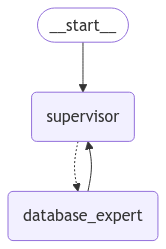

In [38]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

### Вызовы без памяти

In [42]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Сравни одобренные заявки мужчинам и женщинам, учитывый только основных заемщиков"
        }
    ]
})

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Сравни одобренные заявки мужчинам и женщинам, учитывающий только основных заемщиков
```sql
SELECT 
    c.sex,
    COUNT(*) AS approved_applications
FROM 
    application a
JOIN 
    decision d ON a.application_num = d.application_num AND d.decision = 1
JOIN 
    client cl ON a.application_num = cl.application_num AND cl.client_num = 0
JOIN 
    application_category ac ON a.application_category_code = ac.application_category_code
WHERE 
    cl.sex IN ('male', 'female')
GROUP BY 
    c.sex;
```


In [43]:
len(result['messages'])

7

In [44]:
for i in result['messages']:
    print(i)
    print('='*100)

content='Сравни одобренные заявки мужчинам и женщинам, учитывый только основных заемщиков' additional_kwargs={} response_metadata={} id='3c1b32f1-e90c-4f9b-939e-1feb0aac1059'
content='' additional_kwargs={'function_call': {'name': 'transfer_to_database_expert', 'arguments': {'query': 'Сравни одобренные заявки мужчинам и женщинам, учитывый только основных заемщиков'}}, 'functions_state_id': '5d53bf8f-2722-47e7-ab82-1afdc6106b24'} response_metadata={'token_usage': {'prompt_tokens': 117, 'completion_tokens': 39, 'total_tokens': 156}, 'model_name': 'GigaChat-Max:1.0.26.20', 'x_headers': {'x-request-id': 'b87b3231-5174-4dba-9906-5e00ec74d5a3', 'x-session-id': '3d191260-1e4b-4eed-b07d-ce7e4f704815', 'x-client-id': None}, 'finish_reason': 'function_call'} name='supervisor' id='b87b3231-5174-4dba-9906-5e00ec74d5a3' tool_calls=[{'name': 'transfer_to_database_expert', 'args': {'query': 'Сравни одобренные заявки мужчинам и женщинам, учитывый только основных заемщиков'}, 'id': 'bc0e228a-f9d4-4877-

### Добавляем память

In [18]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

In [19]:
checkpointer = InMemorySaver()
# store = InMemoryStore()

In [20]:
config = {"configurable": {"thread_id": "8"}}

In [24]:
app = workflow.compile(
    checkpointer=checkpointer
)

In [25]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            # "content": "Какой средний процент по одобренным ипотекам? Приведи ответ в разрезе по месяцам за последние 6 месяцев"
            "content": "Есть ли полученных данных по одобренным ипотекам аномалии?"

        }
    ]
}, config=config)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Есть ли полученных данных по одобренным ипотекам аномалии?
```sql
SELECT *
FROM application a
JOIN decision d ON a.application_num = d.application_num
WHERE d.decision = 1
ORDER BY requested_sum DESC
LIMIT 5;
```
[{'application_num': 4052, 'application_dt': '2024-05-03', 'subproduct_code': 4567, 'application_category_code': 'A', 'channel_code': 7, 'requested_sum': 980469, 'requested_term_month': 298, 'interest_rate': 16.41, 'payment': 2016.51, 'income': 637361, 'liability': 34151, 'initial_payment_rate': 27, 'expected_model_risk': 0.07836, 'territory_bank_code': 10, 'decision': 1, 'reject_rule_code': None}, {'application_num': 4041, 'application_dt': '2024-04-26', 'subproduct_code': 1234, 'application_category_code': 'A', 'channel_code': 20, 'requested_sum': 963860, 'requested_term_month': 210, 'interest_rate': 28.47, 'payment': 4969.22, 'income': 740784, 'liability': 35331, 'initial_pa

In [26]:
for i in result['messages']:
    print(i)
    print('='*100)

content='Какой средний процент по одобренным ипотекам? Приведи ответ в разрезе по месяцам за последние 6 месяцев' additional_kwargs={} response_metadata={} id='f2fd2dd1-9299-4117-9ba1-245e797658a2'
content='' additional_kwargs={'function_call': {'name': 'transfer_to_database_expert', 'arguments': {'query': 'Какой средний процент по одобренным ипотекам? Приведи ответ в разрезе по месяцам за последние 6 месяцев'}}, 'functions_state_id': '2e82693a-158f-4e48-aab7-f601e127153f'} response_metadata={'token_usage': {'prompt_tokens': 59, 'completion_tokens': 46, 'total_tokens': 105}, 'model_name': 'GigaChat-Max:1.0.26.20', 'x_headers': {'x-request-id': '94da7542-299d-4b89-b94d-b45af583f1cd', 'x-session-id': '7262b15c-a22f-4527-bea1-f316b6f7a2d6', 'x-client-id': None}, 'finish_reason': 'function_call'} name='supervisor' id='94da7542-299d-4b89-b94d-b45af583f1cd' tool_calls=[{'name': 'transfer_to_database_expert', 'args': {'query': 'Какой средний процент по одобренным ипотекам? Приведи ответ в раз

In [ ]:
qqq = '''Средний процент по одобренным ипотекам варьируется от месяца к месяцу. Например, в марте 2024 года он составил 18.925%, в апреле 2024 года — 18.13375%, а в мае 2024 года — 16.60125%.. Данные на которых получен ответ: [{'month': '2024-03', 'average_interest_rate': 18.925}, {'month': '2024-04', 'average_interest_rate': 18.13375}, {'month': '2024-05', 'average_interest_rate': 16.60125}, {'month': '2024-06', 'average_interest_rate': 20.14}, {'month': '2024-07', 'average_interest_rate': 21.1775}, {'month': '2024-08', 'average_interest_rate': 13.62}, {'month': '2024-09', 'average_interest_rate': 11.986666666666666}, {'month': '2024-10', 'average_interest_rate': 15.425}, {'month': '2024-11', 'average_interest_rate': 18.23}, {'month': '2024-12', 'average_interest_rate': 11.97}, {'month': '2025-01', 'average_interest_rate': 16.754444444444445}, {'month': '2025-02', 'average_interest_rate': 20.583333333333332}]'''

In [ ]:
www = model_max.invoke(input=qqq + '. Есть ли аномалии в этих данных?')

In [ ]:
print(www.content)

### Сохраняем локально файлы

In [ ]:
sql = '''SELECT 
    c.sex, 
    COUNT(*) AS total_applications, 
    SUM(d.decision) AS approved_applications, 
    ROUND(100.0 * SUM(d.decision) / COUNT(*), 2) AS approval_percentage
FROM 
    client c
JOIN 
    decision d ON c.application_num = d.application_num
GROUP BY 
    c.sex;
'''

In [ ]:
# aaa = db.run(sql, include_columns=True)

In [ ]:
# print(aaa)

In [ ]:
# json.loads(aaa)

In [ ]:
df = pd.read_sql_query(sql, conn)

In [ ]:
aaa = df.to_json()

In [ ]:
type(aaa)

In [ ]:
aaa

In [ ]:
print(df)

In [ ]:
print(df.to_string())

In [ ]:
вот ответ
```
      sex  total_applications  approved_applications  approval_percentage
0  female                 111                     57                51.35
1    male                 105                     59                56.19
```

In [ ]:
from typing import Annotated

# from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

# @tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


In [ ]:
chart_agent = create_react_agent(
    model_pro,
    [python_repl_tool],
    prompt="Ты - великолепный агент, который умеет только строить графики. На основе полученного вопроса"
)

In [ ]:
chart_agent.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Построй график - на оси x значения [1, 2, 3], на оси y - [3, 4, 2]"
        }
    ]
})